In [ ]:
mlflow ui --port 8082 --backend-store-uri sqlite:///mlruns.db

In [1]:
import os
from joblib import dump, load
from datetime import datetime

import mlflow
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.stats import randint, uniform, loguniform

from sklearn import set_config
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, mean_absolute_error
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import PowerTransformer, FunctionTransformer, StandardScaler
from sklearn.compose import TransformedTargetRegressor, make_column_transformer, ColumnTransformer
from xgboost.sklearn import XGBRegressor

from src.evaluation import *
from src.experiments import optimize_params
from src.feature_engineering import DataEnhancer, AnomaliesMarker
from src.utils import return_train_test_data, weighted_mean
from src.data_visuals import histplots_grid

In [2]:
mlflow.set_tracking_uri("sqlite:///mlruns.db")

pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)

set_config(transform_output="pandas")
ConvergenceWarning("ignore")

SEED = 42

In [3]:
file_path = os.path.join("data", "energydata_complete.csv")
data = pd.read_csv(file_path)

data.date = pd.to_datetime(data.date, format="%d-%m-%Y %H:%M")
data.set_index("date", inplace=True)

data["Appliances_24"] = data.Appliances.shift(-24*6) # target variable
data.dropna(inplace=True)

enhancer = DataEnhancer(data)
enhanced_data = (enhancer
                 .add_datetime_features()
                 .drop_features(["RH_6"])
                 .data)

enhanced_data.head(3)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,Appliances_24,day_of_week,hour,minute,time_of_day,week_of_year,day_of_year,is_holiday,is_weekend
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,17.2,41.626667,18.2,48.900000,17.033333,45.53,6.60,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433,60.0,Monday,17,0,evening,2,11,0,0
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,17.2,41.560000,18.2,48.863333,17.066667,45.56,6.48,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195,60.0,Monday,17,10,evening,2,11,0,0
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,17.2,41.433333,18.2,48.730000,17.000000,45.50,6.37,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668,210.0,Monday,17,20,evening,2,11,0,0


In [4]:
data.shape, enhanced_data.shape

((19591, 29), (19591, 36))

# Prediction benchmarks

For reference points in making predictions, the following options were adopted:

* Values from the previous week (same weekday and time).
* Historical averages for the specific hour and minute, calculated using training data.
* A simple linear regression model was applied to the original dataset, which has been enhanced with basic datetime features (as above), data scaling and a logarithmic transformation of the target variable.

The scores achieved are presented below.

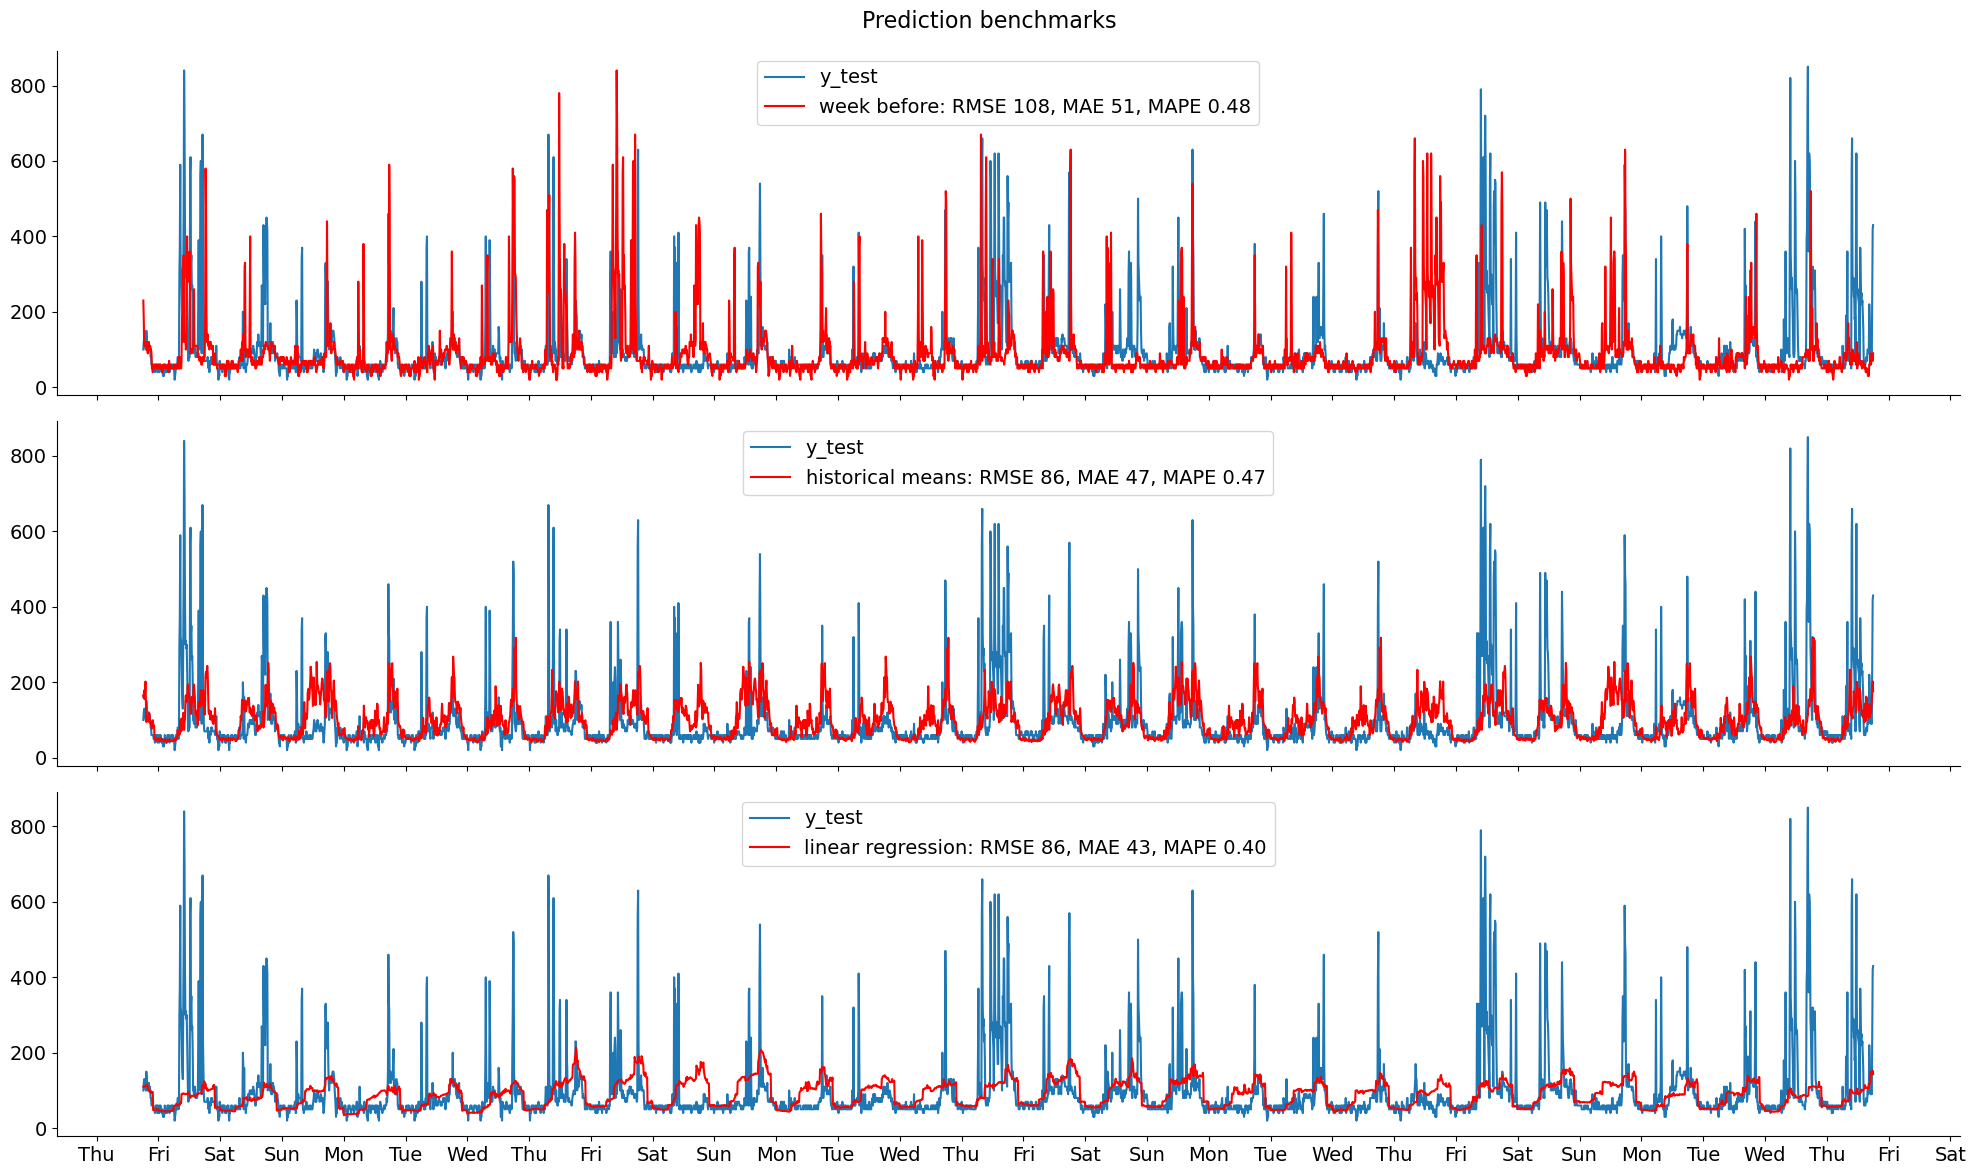

In [5]:
n_test = 4*144*7 # 4 weeks ~ 20,4%
prediction_benchmarks(enhanced_data, n_test)

# Experiments

In the initial experiments, data augmented with additional features (based on *0_data_exploration.ipynb*) were used. Two linear algorithms with regularization and four ensembles (including two boosting ones) were applied. During optimization using pipelines, in addition to model hyperparameters, transformations such as logarithmization and scaling (for linear models), marking anomalies in data using Isolation Forest and transformations of the target variable were also applied.

In [6]:
lags = [1, 2, 3, 6, 24, 72, 144]
mov_windows = [2, 3, 6, 24, 72, 144]
# n_test = 4*144*7

enhanced_data = (enhancer
                 .mark_high_values()
                 .mark_empty_home_days()
                 .add_lagged_features(lags=lags)
                 .add_moving_average(windows=mov_windows)
                 .add_moving_sum(windows=mov_windows)
                 .dropna()
                 .data)

X_train_lin, X_test_lin, y_train, y_test = return_train_test_data(enhanced_data,
                                                                  n_test,
                                                                  xy=True,
                                                                  ohe_drop_first=True)
X_train_tree, X_test_tree, *_  = return_train_test_data(enhanced_data,
                                                          n_test,
                                                          xy=True)
X_train_lin.head(3)

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2,hour,minute,week_of_year,day_of_year,is_holiday,is_weekend,is_high_usage,is_empty_home,lag_1,lag_2,lag_3,lag_6,lag_24,lag_72,lag_144,moving_av_2,moving_av_3,moving_av_6,moving_av_24,moving_av_72,moving_av_144,moving_sum_2,moving_sum_3,moving_sum_6,moving_sum_24,moving_sum_72,moving_sum_144,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_evening,time_of_day_forenoon,time_of_day_morning,time_of_day_night
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-12 17:00:00,0.0,20.066667,42.833333,19.00,42.418182,19.79,44.700000,19.26,42.560000,17.6,50.90,6.156667,18.138889,37.905556,18.6,45.790000,17.1,43.260,6.50,744.200000,75.000000,7.0,29.000000,2.30,36.465481,36.465481,17.0,0.0,2.0,12.0,0.0,0.0,0.0,0.0,40.0,40.0,40.0,30.0,60.0,50.0,60.0,50.0,46.666667,45.000000,91.250000,92.361111,104.097222,100.0,140.0,270.0,2190.0,6650.0,14990.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2016-01-12 17:10:00,10.0,20.000000,42.672500,19.00,42.433333,19.79,44.663333,19.20,42.560000,17.6,50.90,6.090000,18.100000,37.945455,18.6,45.808333,17.1,43.200,6.32,744.283333,76.666667,7.0,30.833333,2.43,22.628542,22.628542,17.0,10.0,2.0,12.0,0.0,0.0,0.0,0.0,60.0,40.0,40.0,40.0,290.0,50.0,60.0,60.0,53.333333,48.333333,81.666667,92.500000,104.097222,120.0,160.0,290.0,1960.0,6660.0,14990.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2016-01-12 17:20:00,20.0,20.000000,42.530000,18.99,42.471818,19.79,44.590000,19.20,42.626667,17.6,50.79,6.090000,18.100000,38.045000,18.6,45.900000,17.1,43.145,6.13,744.366667,78.333333,7.0,32.666667,2.57,8.756338,8.756338,17.0,20.0,2.0,12.0,0.0,0.0,1.0,0.0,60.0,60.0,40.0,50.0,130.0,40.0,50.0,135.0,110.000000,75.000000,85.000000,94.861111,105.208333,270.0,330.0,450.0,2040.0,6830.0,15150.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [7]:
skewed_features = ([feature for feature in X_train_lin.columns
                   if feature.startswith("lag")
                   or feature.startswith("moving")]
                   + ["Windspeed", "lights"])
num_unique_values = X_train_lin.select_dtypes(exclude="object").nunique()
continuous_features = [col for col in num_unique_values.index if num_unique_values[col] > 3]

log_transformer = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)
sqrt_transformer = FunctionTransformer(func=np.sqrt, inverse_func=np.square)
target_transformations = [log_transformer, sqrt_transformer, None]
anomalies_marker = [AnomaliesMarker(contamination="auto"), "passthrough"]

log_pipe = Pipeline([
    ("log_tr", make_column_transformer(
        (log_transformer, skewed_features),
        remainder="passthrough")),
    ("scaler", StandardScaler())
])

power_tr_pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("power_tr", make_column_transformer(
        (PowerTransformer(), skewed_features),
        remainder="passthrough")),
])

preprocessor = Pipeline([
    ("col_tr", ColumnTransformer([
        ("continuous", log_pipe, continuous_features)
    ], remainder="passthrough")),
    ("marker", AnomaliesMarker())
])

In [8]:
X_train_lin.shape, preprocessor.fit_transform(X_train_lin).shape

((15415, 63), (15415, 64))

In [9]:
EN, Ri, ETR, HGBR, RFR, XGBR = (ElasticNet(max_iter=5000),
                                Ridge(),
                                ExtraTreesRegressor(n_jobs=-1),
                                HistGradientBoostingRegressor(),
                                RandomForestRegressor(n_jobs=-1),
                                XGBRegressor())

models = [model.set_params(random_state=SEED) for model in [EN, Ri, ETR, HGBR, RFR, XGBR]]

for_linear_preprocessor = {
    "regressor__preprocessor__col_tr__continuous": [log_pipe, power_tr_pipe],
    "regressor__preprocessor__marker": anomalies_marker,
    "transformer": target_transformations
}
for_tree_preprocessor = {
    "regressor__preprocessor__col_tr": ["passthrough"],
    "regressor__preprocessor__marker": anomalies_marker,
    "transformer": target_transformations
}

params = [
    {
        "regressor__model__alpha": loguniform(1e-2, 1e2),
        "regressor__model__l1_ratio": uniform(0, 1),
        **for_linear_preprocessor
    },
    {
        "regressor__model__alpha": loguniform(1e-3, 1e2),
        **for_linear_preprocessor
    },
    {
        "regressor__model__n_estimators": randint(100, 200),
        "regressor__model__max_depth": randint(3, 10),
        "regressor__model__min_samples_leaf": randint(5, 100),
        **for_tree_preprocessor
    },
    {
        "regressor__model__learning_rate": loguniform(1e-4, 1e0),
        "regressor__model__max_depth": randint(3, 10),
        "regressor__model__min_samples_leaf": randint(5, 100),
        **for_tree_preprocessor
    },
    {
        "regressor__model__n_estimators": randint(100, 200),
        "regressor__model__max_depth": randint(3, 10),
        "regressor__model__min_samples_leaf": randint(5, 100),
        **for_tree_preprocessor
    },
    {
        "regressor__model__n_estimators": randint(100, 200),
        "regressor__model__max_depth": randint(3, 10),
        "regressor__model__subsample": uniform(0.6, 0.4),
        "regressor__model__colsample_bytree": uniform(0.3, 0.7),
        "regressor__model__min_child_weight": randint(5, 100),
        "regressor__model__learning_rate": loguniform(1e-3, 1e0),
        "regressor__model__gamma": loguniform(1e-3, 1e0),
        "regressor__model__reg_lambda": loguniform(1e-3, 1e1),
        **for_tree_preprocessor
    }
]

## Initial

These experiments adressed issues observed in early tests.

In [11]:
# mlflow.create_experiment(name="Initial_experiments")
mlflow.set_experiment("Initial_experiments")

<Experiment: artifact_location='/home/kasia/DS/energy/Appliances_energy_prediction/mlruns/1', creation_time=1706888180577, experiment_id='1', last_update_time=1706888180577, lifecycle_stage='active', name='Initial_experiments', tags={}>

### Time series split parameters

A significant variation was observed in the results achieved across different splits, as well as notable differences between fitting and prediction scores. Given the irregular nature of the data, this was not surprising; however, it was decided to search for the most stable option for time series splitting to reduce the impact of anomalies in the data and prevent overfitting.\
Although a three-week period (representing 19.6% of the training data) might seem like the optimal validation set, this would allow for a maximum of three splits only. To explore whether using 5/10 splits could improve the quality and accuracy of the assessment, a week (comprising 1008 observations) was considered the minimum period that the validation set should include.

To select the best variant of the time series split, 11 sets of parameters for 6 models were tested. For each, the following metrics were recorded:

* The difference between train and test for the best mean test score
* The standard deviation from all splits forming the aforementioned results
* The average difference between train/test scores in subsequent iterations
* The average difference in standard deviation for train/test from subsequent iterations
* The average standard deviation for mean train scores and mean test scores from subsequent iterations

A simplified approach was applied where the results were aggregated into a single score: all the aforementioned metrics were normalized and their weighted average was calculated, assigning the greatest weight to the RMSE metric.

In [51]:
week = 144*7
day = 144

tss_params_set = [
    {"n_splits": 3, "max_train_size": None, "test_size": 3*week, "gap": day},
    {"n_splits": 3, "max_train_size": None, "test_size": 3*week, "gap": 3*day},
    {"n_splits": 3, "max_train_size": None, "test_size": 3*week, "gap": 0},
    {"n_splits": 5, "max_train_size": None, "test_size": 2*week, "gap": day},
    {"n_splits": 5, "max_train_size": None, "test_size": 2*week, "gap": 3*day},
    {"n_splits": 5, "max_train_size": 8*week, "test_size": 2*week, "gap": 0},
    {"n_splits": 5, "max_train_size": None, "test_size": 2*week, "gap": 0},
    {"n_splits": 10, "max_train_size": None, "test_size": week, "gap": day},
    {"n_splits": 10, "max_train_size": None, "test_size": week, "gap": 3*day},
    {"n_splits": 10, "max_train_size": 8*week, "test_size": week, "gap": 0},
    {"n_splits": 10, "max_train_size": None, "test_size": week, "gap": 0}
]

for i, tss_params in enumerate(tss_params_set):

    with mlflow.start_run(run_name=f"TSS_params_{i}",
                          tags={"level": "parent",
                                "iter_id": i}) as parent_run:
        
        tss = TimeSeriesSplit(**tss_params)
        mlflow.log_params(tss_params)

        for model, param in zip(models, params):
            name = model.__class__.__name__

            with mlflow.start_run(run_name=f"{name}",
                                  nested=True,
                                  tags={"level": "child",
                                        "iter_id": i}) as child_run:
            
                
                    X_train = X_train_lin if name in ["Ridge", "ElasticNet"] else X_train_tree
                
                    optimizer = optimize_params(preprocessor,
                                                model,
                                                param,
                                                X_train, y_train,
                                                tss,
                                                rscv_kw={"return_train_score": True})
                
                    cv_results = optimizer.cv_results_
                
                    for metric in ["rmse", "mae", "mape"]:
                        best_index = np.argmin(cv_results[f"rank_test_{metric}"])           
                        best_score = cv_results[f"mean_test_{metric}"][best_index]
                        best_score_train = cv_results[f"mean_train_{metric}"][best_index]
                        diff_best_test_train = np.abs(best_score - best_score_train)
                        std_test_best_score = cv_results[f"std_test_{metric}"][best_index]
                        std_train_best_score = cv_results[f"std_train_{metric}"][best_index]
                        diff_test_train_scores = np.abs(cv_results[f"mean_test_{metric}"]
                                                        - cv_results[f"mean_train_{metric}"])
                        mean_diff_test_train = diff_test_train_scores.mean()
                        std_test_mean = cv_results[f"std_test_{metric}"].mean()
                        std_train_mean = cv_results[f"std_train_{metric}"].mean()
                        diff_std_test_train = np.abs(cv_results[f"std_test_{metric}"]
                                                     - cv_results[f"std_train_{metric}"])
                        mean_diff_std_test_train = diff_std_test_train.mean()
                
                        metrics_to_log = {
                            f"diff_best_{metric}": diff_best_test_train,
                            f"std_test_best_{metric}": std_test_best_score,
                            f"std_train_best_{metric}": std_train_best_score,
                            f"mean_diff_{metric}": mean_diff_test_train,
                            f"mean_diff_std_{metric}": mean_diff_std_test_train,
                            f"std_test_mean_{metric}": std_test_mean,
                            f"std_train_mean_{metric}": std_train_mean
                        }
                        mlflow.log_metrics(metrics_to_log)
                    mlflow.log_params(tss_params)

In [139]:
runs = mlflow.search_runs(experiment_ids=["1"])
grouped = runs.groupby(["tags.mlflow.parentRunId", "tags.iter_id"])[[col for col in runs if "metric" in col]].mean()
scaled = MinMaxScaler().fit_transform(grouped)

weights = {col: 2 if "rmse" in col else 1 for col in scaled.columns}

scaled["overall_score"] = scaled.apply(lambda row: weighted_mean(row, weights), axis=1)
scaled[["overall_score"]].sort_values(by="overall_score").head()

,,overall_score
tags.mlflow.parentRunId,tags.iter_id,
2d91279c762347af9fdf09e776cb5010,2,0.193
61176ded54c34e7ba63cb7bf35504fde,0,0.217
dae7e9f488b647fd8c47091f935b71af,1,0.281
8c468e41dfff4d9382d581498d72e1fe,3,0.295
0229891d30d1412b94794586877ec0b4,4,0.321


Best time series split scheme:

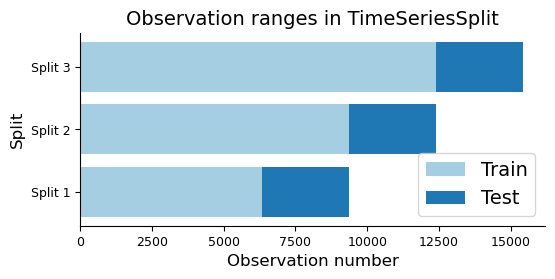

In [157]:
tss_params = {"n_splits": 3, "max_train_size": None, "test_size": 3*week, "gap": 0}
tss = TimeSeriesSplit(**tss_params)
time_series_split(tss, X_train_tree)

### Sample weight

Since the models in previous tests have consistently underestimated high values of the target variable (typically up to 200), it was tested whether increasing the weight for observations with high values would improve this situation.

In [164]:
np.quantile(y_train, 0.90)

210.0

In [166]:
threshold = np.quantile(y_train, 0.90)
weights = [1, 2, 3, 5, 10]

for weight in weights:
    sample_weight = np.where(y_train > threshold, weight, 1)
    
    with mlflow.start_run(run_name=f"Weighing_samples_{weight}",
                          tags={"level": "parent"}) as parent_run:
    
        for model, param in zip(models, params):
    
            name = model.__class__.__name__
    
            with mlflow.start_run(run_name=f"{name}",
                                  nested=True,
                                  tags={"level": "child"}) as child_run:
    
                X_train, X_test = ((X_train_lin, X_test_lin)
                                   if name in ["Ridge", "ElasticNet"] 
                                   else (X_train_tree, X_test_tree))

                optimizer = optimize_params(preprocessor,
                                            model,
                                            param,
                                            X_train, y_train,
                                            tss,
                                            rscv_kw={"return_train_score": True},
                                            fit_kw={"model__sample_weight": sample_weight})
    
                input_example = X_test[:10]
                output_example = optimizer.best_estimator_.predict(input_example)
                n_cols = X_train.shape[1]
                cv_results = optimizer.cv_results_
    
                mlflow.log_params({
                    **optimizer.best_params_,
                    "lags": lags,
                    "moving_windows": mov_windows,
                    "n_cols": n_cols,
                    "weight": weight
                    })
    
                for metric in ["rmse", "mae", "mape"]:
                    best_index = np.argmin(cv_results[f"rank_test_{metric}"])
            
                    best_score = cv_results[f"mean_test_{metric}"][best_index]
                    best_score_train = cv_results[f"mean_train_{metric}"][best_index]
                    std_test_score = cv_results[f"std_test_{metric}"][best_index]
                    std_train_score = cv_results[f"std_train_{metric}"][best_index]
    
                    mlflow.log_metrics({f"best_{metric}": np.abs(best_score),
                                        f"best_{metric}_train": np.abs(best_score_train),
                                        f"std_{metric}_test": std_test_score,
                                        f"std_{metric}_train": std_train_score})
    
                signature = mlflow.models.infer_signature(input_example,
                                                          output_example)
    
                mlflow.sklearn.log_model(sk_model=optimizer.best_estimator_,
                                         artifact_path="",
                                         signature=signature,
                                         registered_model_name=name)

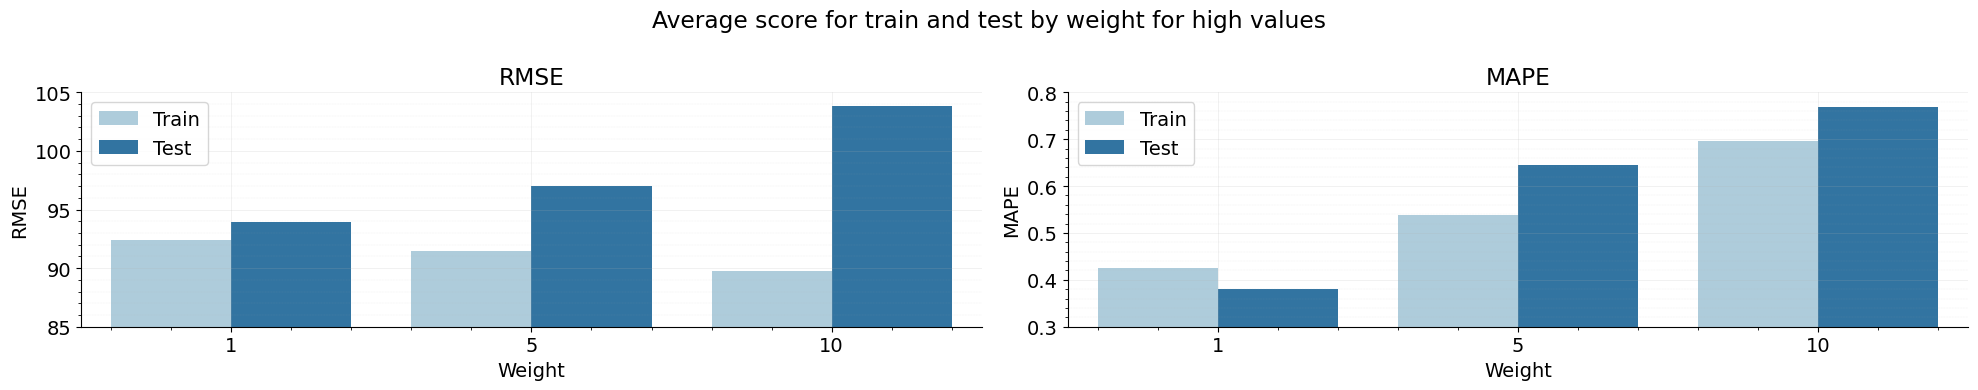

In [163]:
last_runs = os.listdir("mlruns/1")
runs = mlflow.search_runs(experiment_ids=["1"])
filtered_runs = runs[runs.apply(lambda x: x.isin(last_runs)).any(axis=1)]

filtered_runs = (filtered_runs.groupby(["params.weight"])[['metrics.best_mape', 'metrics.best_mape_train',
                                                          'metrics.best_rmse', 'metrics.best_rmse_train',
                                                          'metrics.best_mae', 'metrics.best_mae_train']]
                 .mean()
                 .reset_index())

scores_for_weights(filtered_runs)

As one can see above, increasing weight for observations with high values worsened the results.

## Best model so far:

In [10]:
conn = sqlite3.connect("mlruns.db")

artifact_info = pd.read_sql(
    """
    SELECT 
        runs.run_uuid, 
        params.value AS weight, 
        runs.artifact_uri, 
        metrics.value AS best_rmse
    FROM 
        runs
    JOIN 
        metrics ON metrics.run_uuid = runs.run_uuid AND metrics.key = 'best_rmse'
    JOIN 
        params ON params.run_uuid = runs.run_uuid AND params.key = 'weight'
    ORDER BY 
        metrics.value ASC
    LIMIT 1
    """,
    conn
)

conn.close()

artifact_uri = artifact_info.loc[0, "artifact_uri"]
artifact_info[["run_uuid", "weight", "best_rmse"]]

,run_uuid,weight,best_rmse
0,6894841b4bfa4228909e462bf08bcdfc,1,91.982148


In [12]:
loaded_model = mlflow.sklearn.load_model(artifact_uri)

# fitting to the full training set
mean_squared_error(y_train, loaded_model.predict(X_train_tree), squared=False).round(2)

84.73

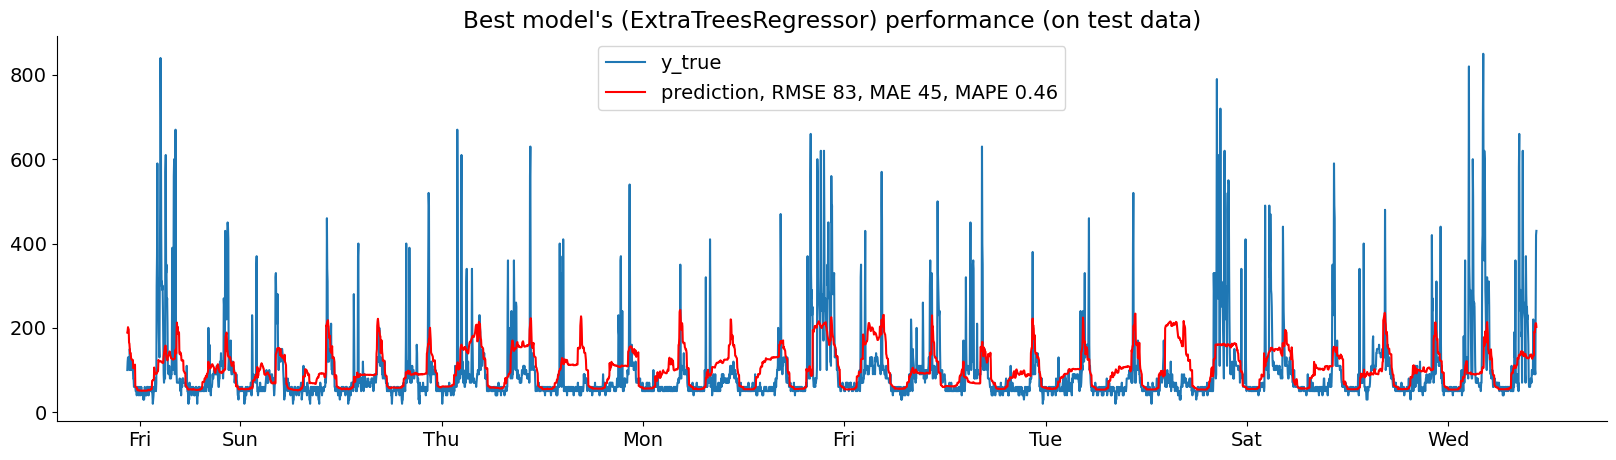

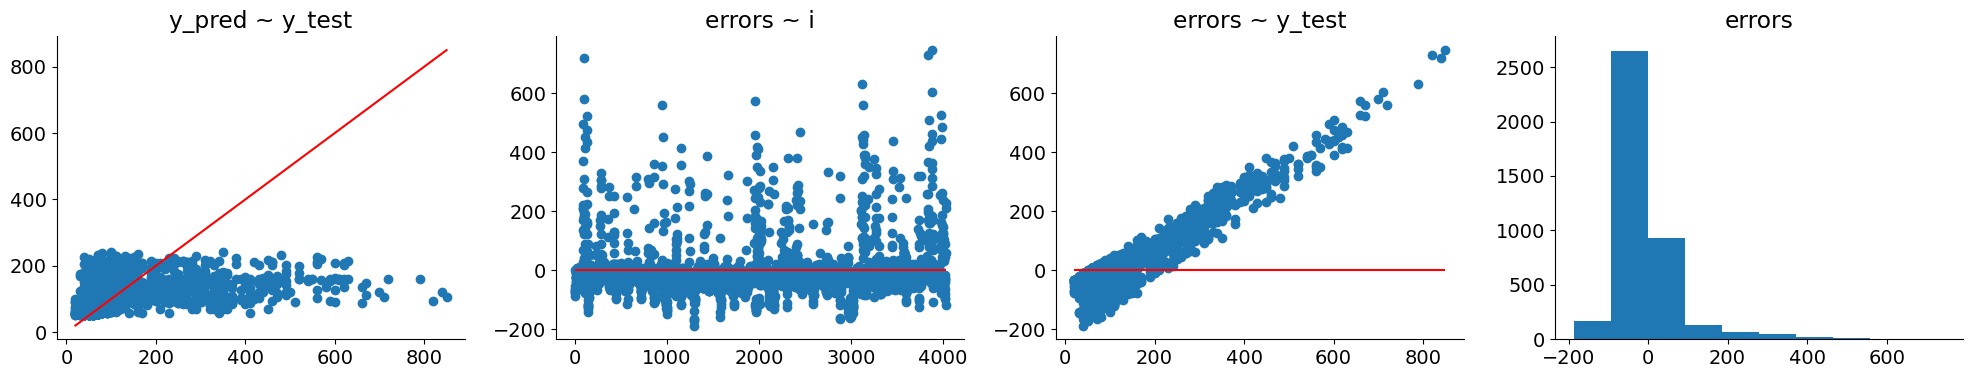

In [13]:
evaluate_model(X_test_tree, y_test, loaded_model)

The presented RMSE result, being significantly better than the result obtained during optimization, may indicate that increasing the training set size has notably improved the model's predictive capabilities.\
Conversely, a slightly worse fit to the full training set than to the test set predictions might suggest that the test set is easier to predict, while the training set, for instance, contains more anomalies - which would align with the characteristics of the data. This may also suggest that the model generalizes well.

**y_pred vs. y_test**: The first chart presents the predicted values (y_pred) in relation to the actual ones (y_test). The ideal line (red) shows where the predicted values equal the actual values. The chart indicates that for larger y_test values, the model tends to underestimate the values.\
**errors vs. i**: The second chart is a scatterplot of errors relative to the observation index. Points should be randomly distributed around the horizontal y=0 line - it seems they are, although large errors appear to coincide with the occurrence of high values in y_true, suggesting that the larger the actual values, the bigger the errors.\
**errors vs. y_test**: The third chart shows an increase in errors as the y_test values rise, confirming the above observation.\
**errors histogram**: The distribution of errors is relatively symmetrical but slightly shifted to the right, indicating that the model more frequently underestimates values.

The measures taken so far to prevent issues such as transformations neutralizing the impact of rare values, using models that are insensitive to them, increasing the weight, and additional marking for significant rare values, have not been very helpful. Improvement was observed with the creation of additional features, but the result is not satisfactory. Clipping outlier values was also tested (not included), which somewhat improved the metric values (especially for linear models), but did not solve the aforementioned problems.

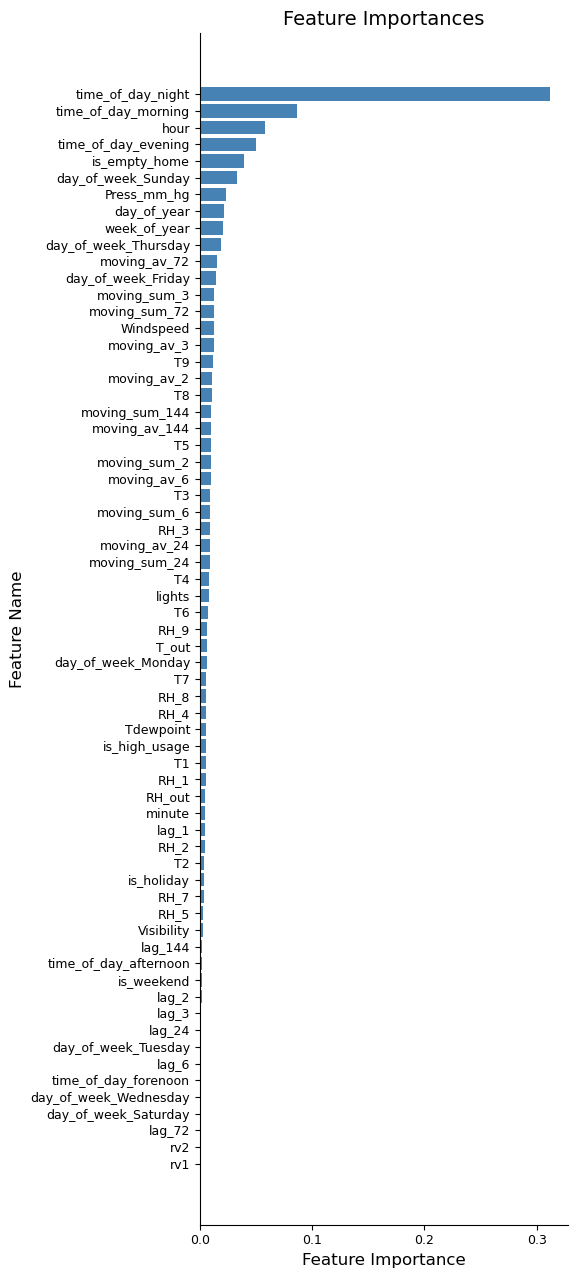

In [31]:
importances = loaded_model.regressor_.named_steps["model"].feature_importances_
cols = list(X_train_tree.columns)
# cols.append("anomalies")
feature_importances(importances, cols)

The model correctly identified the random variables as the least important. They will be removed before the next tests, along with a few other least important features.

## Cyclic and interaction features

In [8]:
to_drop_features = ["rv1", "rv2", "lag_6", "lag_24", "lag_72"]

enhanced_data = (enhancer
                 .drop_features(to_drop_features)
                 .add_cyclic_features()
                 .add_interaction_features(datetime=True, climate=True)
                 .data)

X_train_lin, X_test_lin, y_train, y_test = return_train_test_data(enhanced_data,
                                                                  n_test,
                                                                  xy=True,
                                                                  ohe_drop_first=True)
X_train_tree, X_test_tree, *_  = return_train_test_data(enhanced_data,
                                                          n_test,
                                                          xy=True)
X_train_lin.head(3)

,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,RH_5,T6,T7,RH_7,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,hour,minute,week_of_year,day_of_year,is_holiday,is_weekend,is_high_usage,is_empty_home,lag_1,lag_2,lag_3,lag_144,moving_av_2,moving_av_3,moving_av_6,moving_av_24,moving_av_72,moving_av_144,moving_sum_2,moving_sum_3,moving_sum_6,moving_sum_24,moving_sum_72,moving_sum_144,hour_sin,hour_cos,weekday_sin,weekday_cos,timeofday_sin,timeofday_cos,hour_min,weekday_hour,weekday_timeofday,T1_RH_1,T2_RH_2,T3_RH_3,T4_RH_4,T5_RH_5,T7_RH_7,T8_RH_8,T9_RH_9,T_out_RH_out,T_out_Windspeed,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,time_of_day_evening,time_of_day_forenoon,time_of_day_morning,time_of_day_night
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2016-01-12 17:00:00,0.0,20.066667,42.833333,19.00,42.418182,19.79,44.700000,19.26,42.560000,17.6,50.90,6.156667,18.138889,37.905556,18.6,45.790000,17.1,43.260,6.50,744.200000,75.000000,7.0,29.000000,2.30,17.0,0.0,2.0,12.0,0.0,0.0,0.0,0.0,40.0,40.0,40.0,60.0,50.0,46.666667,45.000000,91.250000,92.361111,104.097222,100.0,140.0,270.0,2190.0,6650.0,14990.0,-0.965926,-0.258819,0.781831,0.62349,-0.951057,0.309017,17.000000,36.0,10.0,859.522222,805.945455,884.613000,819.7056,895.840,687.564661,851.694,739.7460,487.500000,45.50,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2016-01-12 17:10:00,10.0,20.000000,42.672500,19.00,42.433333,19.79,44.663333,19.20,42.560000,17.6,50.90,6.090000,18.100000,37.945455,18.6,45.808333,17.1,43.200,6.32,744.283333,76.666667,7.0,30.833333,2.43,17.0,10.0,2.0,12.0,0.0,0.0,0.0,0.0,60.0,40.0,40.0,60.0,60.0,53.333333,48.333333,81.666667,92.500000,104.097222,120.0,160.0,290.0,1960.0,6660.0,14990.0,-0.965926,-0.258819,0.781831,0.62349,-0.951057,0.309017,17.166667,36.0,10.0,853.450000,806.233333,883.887367,817.1520,895.840,686.812727,852.035,738.7200,484.533333,44.24,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2016-01-12 17:20:00,20.0,20.000000,42.530000,18.99,42.471818,19.79,44.590000,19.20,42.626667,17.6,50.79,6.090000,18.100000,38.045000,18.6,45.900000,17.1,43.145,6.13,744.366667,78.333333,7.0,32.666667,2.57,17.0,20.0,2.0,12.0,0.0,0.0,1.0,0.0,60.0,60.0,40.0,50.0,135.0,110.000000,75.000000,85.000000,94.861111,105.208333,270.0,330.0,450.0,2040.0,6830.0,15150.0,-0.965926,-0.258819,0.781831,0.62349,-0.951057,0.309017,17.333333,36.0,10.0,850.600000,806.539827,882.436100,818.4320,893.904,688.614500,853.740,737.7795,480.183333,42.91,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


Some new features distributions:

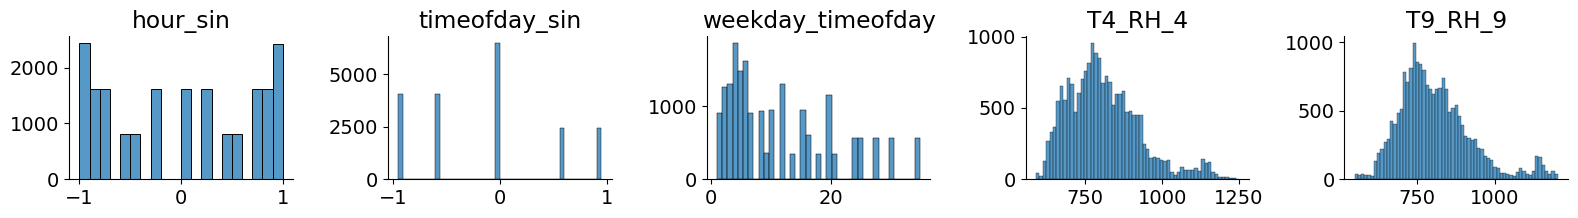

In [41]:
histplots_grid(1, 5, enhanced_data, features = (enhancer.cyclic_features_ + enhancer.interaction_features_)[::4])

Updating preprocessor:

In [48]:
skewed_features = ([feature for feature in skewed_features if feature not in to_drop_features]
                   + ["T5_RH_5"])
continuous_features = ([feature for feature in continuous_features if feature not in to_drop_features]
                       + enhancer.interaction_features_)